In [1]:
#pneunomia  code

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder('./train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder('./val', transform=data_transforms['val'])
test_dataset = datasets.ImageFolder('./test', transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'resnet18': models.resnet18(pretrained=True),
    'alexnet': models.alexnet(pretrained=True),
    'vgg16': models.vgg16(pretrained=True),
    'squeezenet': models.squeezenet1_0(pretrained=True),
    'densenet': models.densenet121(pretrained=True)
}

for model_name, model in models_dict.items():
    if model_name == 'resnet18':
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == 'densenet':
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_name == 'alexnet' or model_name == 'vgg16':
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    elif model_name == 'squeezenet':
        model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

    models_dict[model_name] = model.to(device)

def train_model(model, criterion, optimizer, num_epochs=100, early_stopping_patience=10):
    model.train()
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        val_acc = validate_model(model, criterion)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

def validate_model(model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    return val_acc

def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

criterion = nn.CrossEntropyLoss()
num_epochs = 100

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, num_epochs=num_epochs, early_stopping_patience=10)
    print(f"\nTesting {model_name} on the test set...")
    test_model(model)

c:\Users\AIML\anaconda3\envs\chandra\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AIML\anaconda3\envs\chandra\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\AIML\anaconda3\envs\chandra\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weigh


Training resnet18...


100%|██████████| 163/163 [02:35<00:00,  1.05it/s]


Epoch [1/100], Loss: 0.1344, Accuracy: 94.80%
Validation Loss: 1.1306, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


Epoch [2/100], Loss: 0.5877, Accuracy: 73.73%
Validation Loss: 0.7569, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:23<00:00,  1.95it/s]


Epoch [3/100], Loss: 0.5684, Accuracy: 75.08%
Validation Loss: 0.8744, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:26<00:00,  1.89it/s]


Epoch [4/100], Loss: 0.3538, Accuracy: 84.38%
Validation Loss: 0.8381, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:31<00:00,  1.78it/s]


Epoch [5/100], Loss: 0.2138, Accuracy: 91.33%
Validation Loss: 0.7051, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:31<00:00,  1.78it/s]


Epoch [6/100], Loss: 0.1669, Accuracy: 93.94%
Validation Loss: 0.4852, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [7/100], Loss: 0.1329, Accuracy: 94.75%
Validation Loss: 0.3915, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:33<00:00,  1.73it/s]


Epoch [8/100], Loss: 0.1117, Accuracy: 95.61%
Validation Loss: 0.5685, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [9/100], Loss: 0.1001, Accuracy: 96.15%
Validation Loss: 0.2898, Validation Accuracy: 93.75%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [10/100], Loss: 0.0866, Accuracy: 96.57%
Validation Loss: 0.3859, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [11/100], Loss: 0.0708, Accuracy: 97.49%
Validation Loss: 0.2369, Validation Accuracy: 87.50%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [12/100], Loss: 0.0729, Accuracy: 97.32%
Validation Loss: 0.4712, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [13/100], Loss: 0.0762, Accuracy: 97.14%
Validation Loss: 0.6164, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [14/100], Loss: 0.0554, Accuracy: 97.93%
Validation Loss: 0.4673, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [15/100], Loss: 0.0639, Accuracy: 97.49%
Validation Loss: 0.3465, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [16/100], Loss: 0.0530, Accuracy: 98.08%
Validation Loss: 0.2770, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [17/100], Loss: 0.0502, Accuracy: 97.95%
Validation Loss: 0.5217, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [18/100], Loss: 0.0506, Accuracy: 97.99%
Validation Loss: 0.1287, Validation Accuracy: 93.75%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [19/100], Loss: 0.0420, Accuracy: 98.31%
Validation Loss: 0.2251, Validation Accuracy: 87.50%
Early stopping triggered after 19 epochs.

Testing resnet18 on the test set...
Test Accuracy: 71.63%

Training alexnet...


100%|██████████| 163/163 [01:30<00:00,  1.79it/s]


Epoch [1/100], Loss: 0.6485, Accuracy: 73.47%
Validation Loss: 0.8014, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:31<00:00,  1.77it/s]


Epoch [2/100], Loss: 0.5740, Accuracy: 74.29%
Validation Loss: 0.8764, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:31<00:00,  1.78it/s]


Epoch [3/100], Loss: 0.5712, Accuracy: 74.29%
Validation Loss: 0.7837, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:29<00:00,  1.81it/s]


Epoch [4/100], Loss: 0.5728, Accuracy: 74.29%
Validation Loss: 0.8390, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.81it/s]


Epoch [5/100], Loss: 0.5769, Accuracy: 74.29%
Validation Loss: 0.8348, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.80it/s]


Epoch [6/100], Loss: 0.5714, Accuracy: 74.29%
Validation Loss: 0.8055, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.80it/s]


Epoch [7/100], Loss: 0.5712, Accuracy: 74.29%
Validation Loss: 0.7779, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.81it/s]


Epoch [8/100], Loss: 0.5716, Accuracy: 74.29%
Validation Loss: 0.8274, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:31<00:00,  1.79it/s]


Epoch [9/100], Loss: 0.5717, Accuracy: 74.29%
Validation Loss: 0.8413, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.79it/s]


Epoch [10/100], Loss: 0.5714, Accuracy: 74.29%
Validation Loss: 0.8659, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:30<00:00,  1.79it/s]


Epoch [11/100], Loss: 0.5712, Accuracy: 74.29%
Validation Loss: 0.8528, Validation Accuracy: 50.00%
Early stopping triggered after 11 epochs.

Testing alexnet on the test set...
Test Accuracy: 62.50%

Training vgg16...


100%|██████████| 163/163 [01:42<00:00,  1.59it/s]


Epoch [1/100], Loss: 0.7864, Accuracy: 80.06%
Validation Loss: 1.6583, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:43<00:00,  1.57it/s]


Epoch [2/100], Loss: 0.2126, Accuracy: 91.66%
Validation Loss: 0.9079, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [3/100], Loss: 0.1744, Accuracy: 93.58%
Validation Loss: 0.7112, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [4/100], Loss: 0.1571, Accuracy: 94.13%
Validation Loss: 0.3813, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [5/100], Loss: 0.2600, Accuracy: 92.22%
Validation Loss: 1.2056, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [6/100], Loss: 0.1621, Accuracy: 93.56%
Validation Loss: 0.2236, Validation Accuracy: 93.75%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [7/100], Loss: 0.1017, Accuracy: 96.17%
Validation Loss: 0.1945, Validation Accuracy: 93.75%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [8/100], Loss: 0.1325, Accuracy: 95.19%
Validation Loss: 0.7759, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [9/100], Loss: 0.1652, Accuracy: 94.38%
Validation Loss: 0.6779, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [10/100], Loss: 0.1735, Accuracy: 94.15%
Validation Loss: 0.3771, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [11/100], Loss: 0.1273, Accuracy: 95.19%
Validation Loss: 0.4913, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:41<00:00,  1.61it/s]


Epoch [12/100], Loss: 0.0974, Accuracy: 96.43%
Validation Loss: 0.8014, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [13/100], Loss: 0.1044, Accuracy: 96.11%
Validation Loss: 0.2786, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:42<00:00,  1.60it/s]


Epoch [14/100], Loss: 0.2721, Accuracy: 91.58%
Validation Loss: 1.0798, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [15/100], Loss: 0.2386, Accuracy: 92.04%
Validation Loss: 0.5630, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:41<00:00,  1.60it/s]


Epoch [16/100], Loss: 0.1487, Accuracy: 94.56%
Validation Loss: 2.3362, Validation Accuracy: 56.25%
Early stopping triggered after 16 epochs.

Testing vgg16 on the test set...
Test Accuracy: 75.32%

Training squeezenet...


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [1/100], Loss: 0.4330, Accuracy: 79.14%
Validation Loss: 0.9875, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [2/100], Loss: 0.3103, Accuracy: 87.08%
Validation Loss: 1.4478, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [3/100], Loss: 0.3012, Accuracy: 87.83%
Validation Loss: 1.9309, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [4/100], Loss: 0.2938, Accuracy: 90.34%
Validation Loss: 1.0878, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [5/100], Loss: 0.2709, Accuracy: 91.41%
Validation Loss: 0.6792, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [6/100], Loss: 0.2623, Accuracy: 92.93%
Validation Loss: 1.0718, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [7/100], Loss: 0.2555, Accuracy: 93.02%
Validation Loss: 0.5573, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [8/100], Loss: 0.2596, Accuracy: 93.06%
Validation Loss: 0.8975, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [9/100], Loss: 0.2523, Accuracy: 93.37%
Validation Loss: 3.4409, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:31<00:00,  1.78it/s]


Epoch [10/100], Loss: 0.2508, Accuracy: 93.52%
Validation Loss: 0.6669, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:31<00:00,  1.79it/s]


Epoch [11/100], Loss: 0.2408, Accuracy: 94.33%
Validation Loss: 0.4184, Validation Accuracy: 87.50%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [12/100], Loss: 0.2556, Accuracy: 93.96%
Validation Loss: 0.6305, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [13/100], Loss: 0.2488, Accuracy: 93.77%
Validation Loss: 1.0537, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [14/100], Loss: 0.2399, Accuracy: 93.92%
Validation Loss: 0.4774, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [15/100], Loss: 0.2395, Accuracy: 94.61%
Validation Loss: 0.7470, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [16/100], Loss: 0.2464, Accuracy: 94.19%
Validation Loss: 1.2039, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [17/100], Loss: 0.2371, Accuracy: 94.61%
Validation Loss: 0.7520, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [18/100], Loss: 0.2339, Accuracy: 95.30%
Validation Loss: 0.7386, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [19/100], Loss: 0.2304, Accuracy: 95.21%
Validation Loss: 0.7752, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [20/100], Loss: 0.2365, Accuracy: 94.92%
Validation Loss: 0.4513, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [21/100], Loss: 0.2253, Accuracy: 95.38%
Validation Loss: 0.4494, Validation Accuracy: 75.00%
Early stopping triggered after 21 epochs.

Testing squeezenet on the test set...
Test Accuracy: 76.92%

Training densenet...


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


Epoch [1/100], Loss: 0.1270, Accuracy: 95.07%
Validation Loss: 0.8220, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch [2/100], Loss: 0.6968, Accuracy: 74.00%
Validation Loss: 0.8391, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:36<00:00,  1.68it/s]


Epoch [3/100], Loss: 0.3897, Accuracy: 83.01%
Validation Loss: 0.5350, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch [4/100], Loss: 0.2139, Accuracy: 91.30%
Validation Loss: 1.2020, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:36<00:00,  1.68it/s]


Epoch [5/100], Loss: 0.1374, Accuracy: 94.80%
Validation Loss: 1.3300, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch [6/100], Loss: 0.1402, Accuracy: 94.77%
Validation Loss: 1.0284, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch [7/100], Loss: 0.1125, Accuracy: 95.76%
Validation Loss: 0.8914, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch [8/100], Loss: 0.1126, Accuracy: 95.67%
Validation Loss: 1.6104, Validation Accuracy: 50.00%


100%|██████████| 163/163 [01:39<00:00,  1.64it/s]


Epoch [9/100], Loss: 0.0963, Accuracy: 96.34%
Validation Loss: 2.6415, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


Epoch [10/100], Loss: 0.1026, Accuracy: 95.95%
Validation Loss: 0.6490, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


Epoch [11/100], Loss: 0.0923, Accuracy: 96.59%
Validation Loss: 0.7568, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:34<00:00,  1.73it/s]


Epoch [12/100], Loss: 0.0801, Accuracy: 97.16%
Validation Loss: 1.0720, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:34<00:00,  1.73it/s]


Epoch [13/100], Loss: 0.0803, Accuracy: 96.99%
Validation Loss: 0.4341, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [14/100], Loss: 0.0794, Accuracy: 96.93%
Validation Loss: 0.3190, Validation Accuracy: 87.50%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [15/100], Loss: 0.0749, Accuracy: 97.28%
Validation Loss: 0.8792, Validation Accuracy: 62.50%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [16/100], Loss: 0.0652, Accuracy: 97.74%
Validation Loss: 0.5246, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [17/100], Loss: 0.0759, Accuracy: 97.05%
Validation Loss: 0.9102, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Epoch [18/100], Loss: 0.0683, Accuracy: 97.47%
Validation Loss: 0.5595, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:33<00:00,  1.73it/s]


Epoch [19/100], Loss: 0.0633, Accuracy: 97.55%
Validation Loss: 0.3022, Validation Accuracy: 81.25%


100%|██████████| 163/163 [01:32<00:00,  1.75it/s]


Epoch [20/100], Loss: 0.0657, Accuracy: 97.35%
Validation Loss: 1.2386, Validation Accuracy: 56.25%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [21/100], Loss: 0.0623, Accuracy: 97.53%
Validation Loss: 0.6141, Validation Accuracy: 75.00%


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Epoch [22/100], Loss: 0.0539, Accuracy: 98.12%
Validation Loss: 0.6319, Validation Accuracy: 68.75%


100%|██████████| 163/163 [01:33<00:00,  1.75it/s]


Epoch [23/100], Loss: 0.0621, Accuracy: 97.60%
Validation Loss: 0.2764, Validation Accuracy: 87.50%


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch [24/100], Loss: 0.0645, Accuracy: 97.66%
Validation Loss: 0.2921, Validation Accuracy: 81.25%
Early stopping triggered after 24 epochs.

Testing densenet on the test set...
Test Accuracy: 77.08%


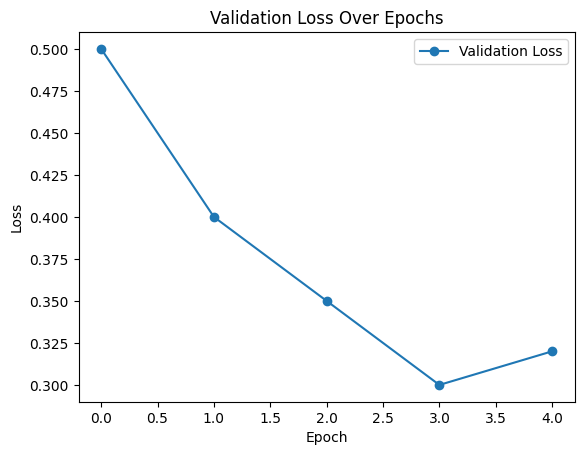

In [ ]:
# Dummy data for illustration
val_loss_history = [0.5, 0.4, 0.35, 0.3, 0.32]

plt.plot(range(len(val_loss_history)), val_loss_history, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


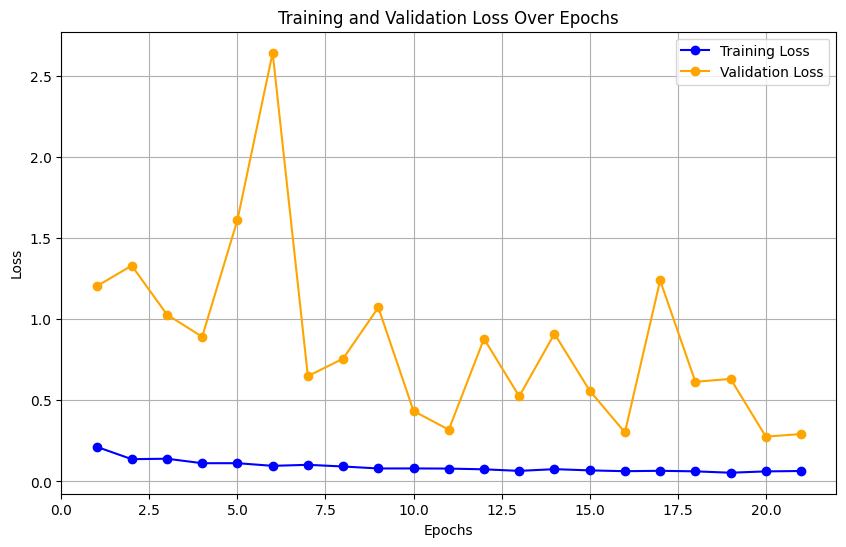

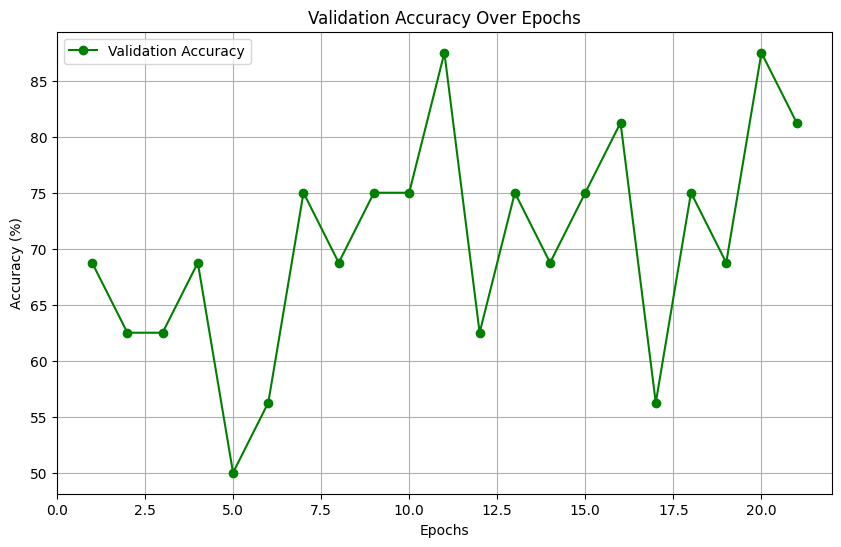

In [9]:
import matplotlib.pyplot as plt

# Truncated data to match lengths
epochs = list(range(1, 22))  # Match the number of epochs with the loss data
train_loss = [
    0.2139, 0.1374, 0.1402, 0.1125, 0.1126, 0.0963, 0.1026, 0.0923, 0.0801,
    0.0803, 0.0794, 0.0749, 0.0652, 0.0759, 0.0683, 0.0633, 0.0657, 0.0623,
    0.0539, 0.0621, 0.0645
]
val_loss = [
    1.2020, 1.3300, 1.0284, 0.8914, 1.6104, 2.6415, 0.6490, 0.7568, 1.0720,
    0.4341, 0.3190, 0.8792, 0.5246, 0.9102, 0.5595, 0.3022, 1.2386, 0.6141,
    0.6319, 0.2764, 0.2921
]
val_acc = [
    68.75, 62.50, 62.50, 68.75, 50.00, 56.25, 75.00, 68.75, 75.00, 75.00, 
    87.50, 62.50, 75.00, 68.75, 75.00, 81.25, 56.25, 75.00, 68.75, 87.50, 81.25
]

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#malaria code
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from sklearn.metrics import accuracy_score
import numpy as np

data_dir = './cell_images'

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),  # Add Gaussian noise
])

dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def create_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(model.classifier.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    elif model_name == "resnet101":
        model = moxels.resnet101(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.8),  # Additional Dropout layer
            nn.Linear(512, 1)
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model

def train_and_evaluate(model_name, patience=3):
    print(f"Training {model_name}...")

    model = create_model(model_name)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

    best_val_loss = float('inf')
    patience_counter = 0
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.round(torch.sigmoid(outputs))
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Evaluation on the validation set
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"{model_name}: {accuracy:.2f} Test Accuracy")
    return accuracy

model_names = [
    "resnet50", "densenet121", "efficientnet_b0", "resnet101", "vgg16", "mobilenet_v2"
]
results = {}

for model_name in model_names:
    accuracy = train_and_evaluate(model_name)
    results[model_name] = accuracy

for model_name, acc in results.items():
    print(f"{model_name}: {acc:.2f} Test Accuracy")
